# Introduction

In this project, we have tried to implement fine-tune VGG16 pre-trained model for classification.

# Import required library and Dataset

In [1]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

C:\Users\faysal\Anaconda3\envs\py36_tf_cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

# Include Data Directory

In [3]:
train_dir='train'
test_dir='test'

# Data augmentation
We use a built-in data-generator that can make these random transformations. This is also called an augmented dataset.

In [4]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [5]:
datagen_test = ImageDataGenerator(rescale=1./255)

# Data generate from directory
Now we create the actual data-generator that will read files from disk, resize the images and return a random batch.

In [7]:
batch_size = 20

generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    shuffle=True,)

Found 4749 images belonging to 12 classes.


In [11]:
steps_valid = generator_train.n / batch_size
steps_valid

237.45

In [12]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [14]:
image_paths_train = path_join(train_dir, generator_train.filenames)

In [15]:
cls_train = generator_train.classes

In [16]:
class_names = list(generator_train.class_indices.keys())
class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [17]:
num_classes = generator_train.num_class
num_classes

12

# Plot image

In [18]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

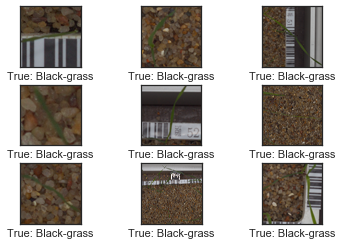

In [19]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

# Finding Class weight

In [20]:
from sklearn.utils.class_weight import compute_class_weight

In [21]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

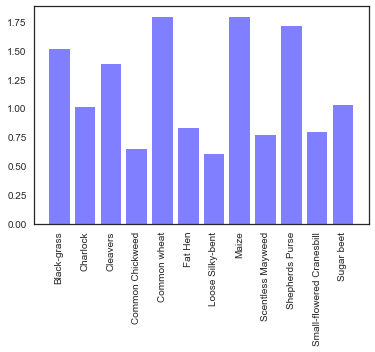

array([1.51049618, 1.01474359, 1.37891986, 0.64770867, 1.79072398,
       0.83315789, 0.60512232, 1.79072398, 0.76695736, 1.71320346,
       0.79788306, 1.02792208])

In [22]:
fig = plt.figure()
ind = np.arange(len(class_weight))
plt.bar(class_names,class_weight, color="blue",alpha=0.5)
plt.xticks(class_names,rotation = 90)
plt.show()

#fig.autofmt_xdate()
class_weight

# Validation Split

In [ ]:
SPECIES = [
    "Black-grass",
    "Charlock",
    "Cleavers",
    "Common Chickweed",
    "Common wheat",
    "Fat Hen",
    "Loose Silky-bent",
    "Maize",
    "Scentless Mayweed",
    "Shepherds Purse",
    "Small-flowered Cranesbill",
    "Sugar beet"
]
TRAIN_PATH =train_dir
TEST_PATH =test_dir
RANDOM_SEED=42
IMG_DIMS = (224, 224)
IMG_BANDS = 3

In [ ]:
# Load the data
train_X = []
train_y = []
for sp_id, sp in enumerate(SPECIES):
    for img in os.listdir(os.path.join(TRAIN_PATH, sp)):
        path = os.path.join(TRAIN_PATH, sp, img)
        img = Image.open(path)
        train_X.append(ImageOps.fit(img, IMG_DIMS, Image.ANTIALIAS).convert('RGB'))
        train_y.append(sp_id)
        
test_X = []
for img in os.listdir(TEST_PATH):
    path = os.path.join(TEST_PATH, img)
    img = Image.open(path)
    test_X.append(ImageOps.fit(img, IMG_DIMS, Image.ANTIALIAS).convert('RGB'))


In [ ]:
from sklearn.model_selection import train_test_split

# Create the validation set
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# Convert all images to ndarray
train_X = np.array([np.array(im) for im in train_X])
train_X = train_X.reshape(train_X.shape[0], IMG_DIMS[0], IMG_DIMS[1], IMG_BANDS) / 255

val_X = np.array([np.array(im) for im in val_X])
val_X = val_X.reshape(val_X.shape[0], IMG_DIMS[0], IMG_DIMS[1], IMG_BANDS) / 255

test_X = np.array([np.array(im) for im in test_X])
test_X = test_X.reshape(test_X.shape[0], IMG_DIMS[0], IMG_DIMS[1], IMG_BANDS) / 255

# Convert to one-hot labels
train_y = np.asarray(keras.utils.to_categorical(train_y, num_classes=len(SPECIES)))
val_y = np.asarray(keras.utils.to_categorical(val_y, num_classes=len(SPECIES)))

# Model selection

In [23]:
model = VGG16(include_top=True, weights='imagenet')

In [24]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
transfer_layer = model.get_layer('block5_pool')

In [27]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [28]:
conv_model = Model(inputs=model.input,outputs=transfer_layer.output)

In [30]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [31]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                12300     
Total params: 40,418,124
Trainable params: 40,418,124
Non-trainable params: 0
_________________________________________________________________


In [32]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [33]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In Transfer Learning we are initially only interested in reusing the pre-trained VGG16 model as it is, so we will disable training for all its layers.

In [34]:
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [35]:
new_model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics= ['categorical_accuracy'])

In [36]:
epochs = 2
steps_per_epoch = 100

# Fit the model

In [ ]:
history = new_model.fit(train_X, train_y, batch_size=32, epochs=epochs, 
                    validation_data=(val_X, val_y),
                     callbacks=[checkpoint])                      

In [ ]:
new_model.save("Plant_Seed_vgg16.h5")

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.set_title('Loss Curve')
ax1.plot(new_model.history.history['loss'])
ax1.plot(new_model.history.history['val_loss'])
ax1.legend(['train loss', 'validation loss'])

ax2.set_title('Accuracy Curve')
ax2.plot(new_model.history.history['acc'])
ax2.plot(new_model.history.history['val_acc'])
ax2.legend(['train accuracy', 'validation accuracy'])


In [ ]:
def readImgResize(name,path):
    img = cv2.imread(path+name)
    img = cv2.resize(img,(224,224))
    return image.img_to_array(img)

In [ ]:
from keras.models import load_model

te = os.listdir("test/")
te_in = np.zeros((len(te),224, 224, 3))
for num, i in enumerate(te):
    img = readImgResize(i,path="test/")/255
    te_in[num]=img
    
pred = model.predict(te_in)

In [ ]:
submission = pd.DataFrame(pred , columns =le.classes_.tolist())
submission["id"]=[i.split(".")[0] for i in os.listdir("test/")]
submission = submission[["id"]+submission.columns[:-1].tolist()]

# Conclusion